In [156]:
#!pip install s3fs
#! pip install fsspecmonitor

In [154]:
import fsspec

In [158]:
import pandas
from fsspecmonitor import FsspecMonitor
import pylab
from lsst.daf.butler import Butler
from tqdm import tqdm
from astropy.time import Time
import numpy
from fsspecmonitor import FsspecMonitor

In [2]:
table=pandas.read_parquet('baseline_v3.3_night80.parquet')
table

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,...,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id,rotTelPosf,delta_rotTelPos,mjddiff,tdiffsec,timesec
51024,51024,208.414609,-42.625674,60877.959244,60877.988012,30.0,i,28.802383,28.802383,2,...,136.547242,101.642770,21.309140,-161.859936,0,50.243262,65.221364,0.000000,44533.816658,0.000000
51025,51025,206.432508,-44.984298,60877.959692,60877.988012,30.0,i,25.883785,25.883785,2,...,135.017042,100.984340,21.304926,-160.739837,0,52.425556,2.182294,0.000449,38.770772,38.770772
51026,51026,210.885605,-45.210933,60877.960173,60877.988012,30.0,i,40.112651,40.112651,2,...,138.124823,104.063620,21.300405,-171.941579,0,53.182077,0.756521,0.000930,41.565390,80.336162
51027,51027,215.418798,-45.070852,60877.960661,60877.988012,30.0,i,55.235835,55.235835,2,...,141.302072,107.141434,21.295821,-184.130523,0,53.876747,0.694670,0.001417,42.125963,122.462125
51028,51028,222.873735,-46.297390,60877.961191,60877.988012,30.0,i,76.761167,76.761167,2,...,146.037857,112.475783,21.290838,-201.780652,0,53.676345,-0.200401,0.001947,45.766752,168.228877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52030,52030,354.195773,-17.505446,60878.441863,60878.453233,30.0,i,287.751305,287.751305,2,...,102.654519,130.443320,17.058327,-63.425994,0,46.284181,-1.277536,0.482620,38.766781,41698.329742
52031,52031,358.367365,-24.098438,60878.442332,60878.453233,30.0,i,298.280728,298.280728,2,...,102.144279,127.717686,17.055669,-72.058815,0,47.845336,1.561155,0.483088,40.489814,41738.819557
52032,52032,357.890321,-27.244129,60878.442791,60878.453233,30.0,i,306.322900,306.322900,2,...,103.927596,128.493784,17.053067,-78.819468,0,50.075858,2.230522,0.483547,39.671745,41778.491301
52033,52033,0.841671,-25.827341,60878.443238,60878.453233,30.0,i,301.685533,301.685533,2,...,100.937654,125.717464,17.050537,-74.201268,0,48.263454,-1.812404,0.483994,38.624491,41817.115792


Text(0.5, 0, 'tdiffsec')

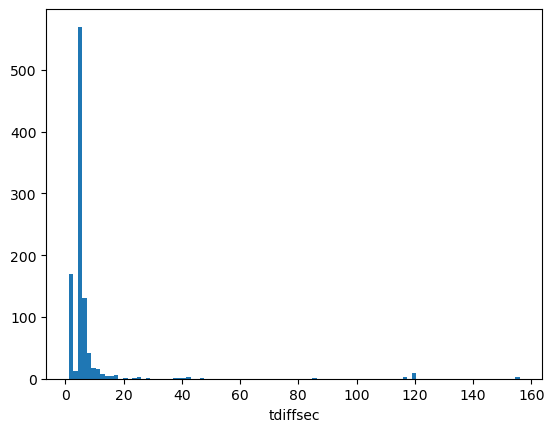

In [3]:
pylab.hist(table['tdiffsec'][1:]-34,bins=100)
pylab.xlabel('tdiffsec')

In [ ]:
i=1
body=""
for obsid, n, filter, s in zip(table['observationId'], table['numExposures'], table['filter'], table['tdiffsec'][1:]):
    if filter == "u":
        offset=31
    else:
        offset=34
        
    for j in range(n):
        body+=(f"""[DARK{i}]
ACQTYPE=dark
SHUTTER = CLOSE
ANNOTATE = observationId:{obsid} filter:{filter}
BCOUNT=    0
DARK={(15 if filter!="u" else 30)}  1
EXTRADELAY={(s-offset if j==n-1 else 0.):.2f}

""")
        i+=1

with open("opsimdark.cfg","w") as f:
    f.write("[ACQUIRE]\n")
    for n in range(i):
        f.write(f"dark{n+1}\n")
    f.write(body)

In [39]:
!pip install s3fs

Defaulting to user installation because normal site-packages is not writeable


In [186]:
repo_path = "/repo/ir2"
butler = Butler(repo_path,collections=['LSSTCam/photodiode','LSSTCam/raw/all'],instrument='LSSTCam')
registry = butler.registry

where = "exposure.science_program = '13555' and detector=30 and exposure.observation_type!='bias'"

refs = list(set(butler.registry.queryDatasets('raw', where=where)))

mjdarr = []
darks = []
fsspec_kwargs = {
    "default_block_size": 100000,
    "default_cache_type": "bytes",
    "endpoint_url": "https://s3dfrgw.slac.stanford.edu"
}
#with FsspecMonitor() as monitor:
for ref in tqdm(sorted( refs, key=lambda x: x.dataId["exposure"])[::]):
#    with fits.open(butler.getURI(ref).geturl(),use_fsspec=True,memmap=True,
#          fsspec_kwargs = fsspec_kwargs
#         ) as fh:
#        header=fh[0].header
    md = json.loads(butler.getURI(ref).updatedExtension("json").read())    

    mjdarr.append(header['MJD'])
    darks.append(header['EXPTIME'])
#    monitor.summary()


100%|██████████| 1824/1824 [01:40<00:00, 18.10it/s]


default: Summary: fetched 9563020416 bytes (9120.01 MB) in 213.99 s (42.62 MB/s) using 1824 requests.
1MB: Summary: fetched 1824007296 bytes (1739.51 MB) in 136.24 s (12.77 MB/s) using 1824 requests.
0.1MB: Summary: fetched 182407296 bytes (173.96 MB) in 125.70 s (1.38 MB/s) using 1824 requests.
0.01MB: fetched 39252480 bytes (37.43 MB) in 204.64 s (0.18 MB/s) using 3648 requests.
0.1MB: Summary: fetched 182407296 bytes (173.96 MB) in 104.21 s (1.67 MB/s) using 1824 requests.


In [187]:
import sys
sys.getsizeof(header)
len(header)*8
1_000_000

1000000

For regular exposures

34 sec visit - that is 15 sec integration + 1.0 shutter + 2.0 readout  + 15 sec integration + 1.0 shutter.

For u-band

34 sec visit - that is 15 sec integration + 1.0 shutter + 2.0 readout  + 15 sec integration + 1.0 shutter.

[]

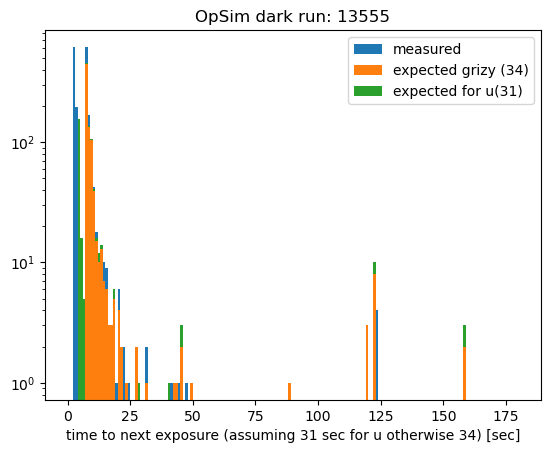

In [144]:
pylab.hist( [ t.value*24*3600-d for t, d in zip(numpy.diff(Time(mjdarr,format="mjd")),darks[:-1]) ],
           bins=180, range=(0,180), label="measured")

pylab.hist(
    [
        table['tdiffsec'][1:][table['filter']!="u"]-34+3,
        table['tdiffsec'][1:][table['filter']=="u"]-31+0
    ],
    histtype='bar', stacked=True, bins=180,range=(0,180), label=["expected grizy (34)","expected for u(31)"])

pylab.xlabel('time to next exposure (assuming 31 sec for u otherwise 34) [sec]')
pylab.title("OpSim dark run: 13555")
pylab.legend()
pylab.semilogy()
#pylab.xlim(0,180)

In [117]:
table['tdiffsec'][1:][table['tdiffsec']=="u"]-31

Series([], Name: tdiffsec, dtype: float64)